In [1]:
#https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b
#interesting

In [1]:
#bibliografia
#https://arxiv.org/pdf/1810.04020.pdf
#https://openaccess.thecvf.com/content_cvpr_2018/papers/Aneja_Convolutional_Image_Captioning_CVPR_2018_paper.pdf
#https://openaccess.thecvf.com/content_ICCV_2019/papers/Huang_Attention_on_Attention_for_Image_Captioning_ICCV_2019_paper.pdf
#https://openaccess.thecvf.com/content_ECCV_2018/papers/Ting_Yao_Exploring_Visual_Relationship_ECCV_2018_paper.pdf
#https://openaccess.thecvf.com/content_cvpr_2018/papers/Anderson_Bottom-Up_and_Top-Down_CVPR_2018_paper.pdf

I'll load required packages and environment variables at the beginning

In [45]:
import tensorflow as tf
import pathlib
import collections
from matplotlib import image
from matplotlib import pyplot
import re
IMAGE_SHAPE = (128,128,3)

Then, I'll prepare tensorflow Dataset based on the tutorial at https://www.tensorflow.org/tutorials/text/image_captioning

In [3]:
#splitting the captions into {'Path': ['Caption1', 'Caption2']} etc
path = pathlib.Path("Flickr8k_text")
captions = (path/"Flickr8k.token.txt").read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
    cap_dict[fname].append(cap)

In [4]:
#view captions
cap_dict = dict(cap_dict)
cap_dict

{'1000268201_693b08cb0e.jpg': ['A child in a pink dress is climbing up a set of stairs in an entry way .',
  'A girl going into a wooden building .',
  'A little girl climbing into a wooden playhouse .',
  'A little girl climbing the stairs to her playhouse .',
  'A little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['A black dog and a spotted dog are fighting',
  'A black dog and a tri-colored dog playing with each other on the road .',
  'A black dog and a white dog with brown spots are staring at each other in the street .',
  'Two dogs of different breeds looking at each other on the road .',
  'Two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'A little girl is sitting in front of a large painted rainbow .',
  'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  'T

I will also clean up the captions

In [5]:
#define function
def captions_clean(image_dict):
    d = {}
    for key, captions in image_dict.items():
        for i, caption in enumerate (captions):
            caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
            clean_words = [word for word in caption_nopunct.split() if ((len(word) > 1) and (word.isalpha()))]
            caption_new = ' '.join(clean_words)
            caption_new = '[START] ' + caption_new + ' [END]'
            captions[i] = caption_new
        d[key] = captions
    return d

#check how the function works
clean_cap_dict = captions_clean(cap_dict)
clean_cap_dict

{'1000268201_693b08cb0e.jpg': ['[START] child in pink dress is climbing up set of stairs in an entry way [END]',
  '[START] girl going into wooden building [END]',
  '[START] little girl climbing into wooden playhouse [END]',
  '[START] little girl climbing the stairs to her playhouse [END]',
  '[START] little girl in pink dress going into wooden cabin [END]'],
 '1001773457_577c3a7d70.jpg': ['[START] black dog and spotted dog are fighting [END]',
  '[START] black dog and tri colored dog playing with each other on the road [END]',
  '[START] black dog and white dog with brown spots are staring at each other in the street [END]',
  '[START] two dogs of different breeds looking at each other on the road [END]',
  '[START] two dogs on pavement moving toward each other [END]'],
 '1002674143_1b742ab4b8.jpg': ['[START] little girl covered in paint sits in front of painted rainbow with her hands in bowl [END]',
  '[START] little girl is sitting in front of large painted rainbow [END]',
  '[STA

I'll also split the dataset into test and train sets and create tf `Dataset` object

In [6]:
photo_path = pathlib.Path("Flicker8k_Dataset")

train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
train_captions = [(str(photo_path/fname), clean_cap_dict[fname]) for fname in train_files]

test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
test_captions = [(str(photo_path/fname), clean_cap_dict[fname]) for fname in test_files]

train_ds = tf.data.experimental.from_list(train_captions)
test_ds = tf.data.experimental.from_list(test_captions)

2023-01-16 23:59:18.747432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
train_captions

[('Flicker8k_Dataset/2513260012_03d33305cf.jpg',
  ['[START] black dog is running after white dog in the snow [END]',
   '[START] black dog chasing brown dog through snow [END]',
   '[START] two dogs chase each other across the snowy ground [END]',
   '[START] two dogs play together in the snow [END]',
   '[START] two dogs running through low lying body of water [END]']),
 ('Flicker8k_Dataset/2903617548_d3e38d7f88.jpg',
  ['[START] little baby plays croquet [END]',
   '[START] little girl plays croquet next to truck [END]',
   '[START] the child is playing croquette by the truck [END]',
   '[START] the kid is in front of car with put and ball [END]',
   '[START] the little boy is playing with croquet hammer and ball beside the car [END]']),
 ('Flicker8k_Dataset/3338291921_fe7ae0c8f8.jpg',
  ['[START] brown dog in the snow has something hot pink in its mouth [END]',
   '[START] brown dog in the snow holding pink hat [END]',
   '[START] brown dog is holding pink shirt in the snow [END]',

The images will be preprocessed using a CNN architecture. I selected densenet201 architecture - here is why:
- tensorflow tutorial uses MobileNetV3Small: https://www.tensorflow.org/tutorials/text/image_captioning 
- there is a tutorial which uses InceptionV3: https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa
- based on https://arxiv.org/pdf/1810.00736.pdf the Densenet201 has similar performance and lower computational complexity than the other 2 mentioned above architectures

Documentations: https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet201

I'll load wegights pre-trained on imagenet

In [8]:
image_model = tf.keras.applications.DenseNet201(include_top=False, 
                                                weights='imagenet',
                                               input_shape = IMAGE_SHAPE)
image_model.trainable = False

In [9]:
print("Input shape: \n", image_model.input, "\n")
print("Output shape: \n", image_model.layers[-1].output, "\n")
img_feature_extraction = tf.keras.Model(image_model.input, image_model.layers[-1].output)

Input shape: 
 KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") 

Output shape: 
 KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1920), dtype=tf.float32, name=None), name='relu/Relu:0', description="created by layer 'relu'") 



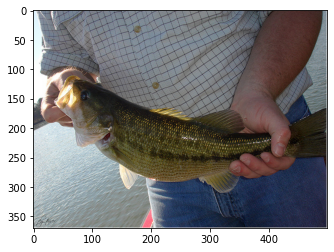

In [48]:
#load examplary image
image2 = image.imread('Flicker8k_Dataset/143237785_93f81b3201.jpg')
pyplot.imshow(image2)
pyplot.show()

In [11]:
#check image resolution
image2.shape

(370, 500, 3)

The pictures need to be resized when loading

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img, image_path

I'll check if there is no error when trying to preprocess one photo and what are the dimentions of input and output.

In [13]:
img, image_path = load_image('Flicker8k_Dataset/143237785_93f81b3201.jpg')
img = tf.expand_dims(img, axis=0)
print("Input shape: ", img.shape)
output = img_feature_extraction(img)
print("Output shape: ", output.shape,)

Input shape:  (1, 128, 128, 3)
Output shape:  (1, 4, 4, 1920)


Until now I loaded the data and preprocessed the captions and wrote a function for feature extraction of images with DenseNet201 CNN architecture. Now I will create dictionary of vocabs.

In [14]:
vocabulary_size = 4000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    ragged=True)

In [15]:
tokenizer.adapt(train_ds.map(lambda fp,txt: txt).unbatch().batch(1024))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

In [16]:
#check last words on a vocab list -whether make sense
tokenizer.get_vocabulary()[-10:]

['jumpsuits',
 'jug',
 'judges',
 'judge',
 'jr',
 'jousting',
 'join',
 'italy',
 'ipod',
 'involved']

Right now the set is in the form:
```
{
'imagepath1' : ['caption1', 'caption2'],  
'imagepath2' : ['caption1', 'caption2']
}
```

And I want to have a set `(image1, caption1), (image1, caption2), (image2, caption1), (image2, caption2)`

In [17]:
train_captions

[('Flicker8k_Dataset/2513260012_03d33305cf.jpg',
  ['[START] black dog is running after white dog in the snow [END]',
   '[START] black dog chasing brown dog through snow [END]',
   '[START] two dogs chase each other across the snowy ground [END]',
   '[START] two dogs play together in the snow [END]',
   '[START] two dogs running through low lying body of water [END]']),
 ('Flicker8k_Dataset/2903617548_d3e38d7f88.jpg',
  ['[START] little baby plays croquet [END]',
   '[START] little girl plays croquet next to truck [END]',
   '[START] the child is playing croquette by the truck [END]',
   '[START] the kid is in front of car with put and ball [END]',
   '[START] the little boy is playing with croquet hammer and ball beside the car [END]']),
 ('Flicker8k_Dataset/3338291921_fe7ae0c8f8.jpg',
  ['[START] brown dog in the snow has something hot pink in its mouth [END]',
   '[START] brown dog in the snow holding pink hat [END]',
   '[START] brown dog is holding pink shirt in the snow [END]',

In [34]:
def data_prep(data_list, tokenizer):
    img_paths, X, y_temp, y_res = list(), list(), list(), list()

    for i, element in enumerate(data_list):
        img_path, captions = element
        image, image_path = load_image(img_path)
        for caption in captions:
            word_idxs = tokenizer(caption)
            y_temp.append(word_idxs)
            X.append(image)
            img_paths.append(image_path)
    
    y_temp = tf.keras.utils.pad_sequences(y_temp, padding = 'post')
    
    for record in y_temp:
        y_res.append(tf.convert_to_tensor(record))
    
    return img_paths, X, y_res

img_paths, train_X, train_y = data_prep(train_captions, tokenizer)

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))


[(array([[[-0.8313358 , -1.1649277 , -1.0109777 ],
          [-1.8274928 , -1.7730494 , -1.6712627 ],
          [-0.80061907, -0.99356145, -0.98723185],
          ...,
          [-1.4559251 , -1.3824084 , -1.2294756 ],
          [-0.77438223, -0.98803276, -0.938858  ],
          [-1.316056  , -1.2784711 , -1.1169752 ]],
  
         [[-1.482944  , -1.4802623 , -1.4330794 ],
          [-1.371585  , -1.360389  , -1.3227831 ],
          [-1.3492206 , -1.335057  , -1.3537269 ],
          ...,
          [-1.1532476 , -1.3102314 , -1.0992004 ],
          [-1.327477  , -1.3427247 , -1.296781  ],
          [-1.1755774 , -1.1593    , -1.1843644 ]],
  
         [[-1.5240657 , -1.5967238 , -1.570295  ],
          [-1.6484762 , -1.6596973 , -1.5518956 ],
          [-1.2583425 , -1.2177875 , -1.2148677 ],
          ...,
          [-1.172653  , -1.1344371 , -1.098678  ],
          [-1.5760577 , -1.4962252 , -1.41448   ],
          [-1.2110989 , -1.2360747 , -1.1924566 ]],
  
         ...,
  
        

Now lets check an example if everything works fine

In [39]:
img_paths[1234]

'Flicker8k_Dataset/2809793070_1a3387cd6e.jpg'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([  2,  47,  58,  15,  31,  17,  35,   6,   5, 309,  66,   5, 143,
         3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

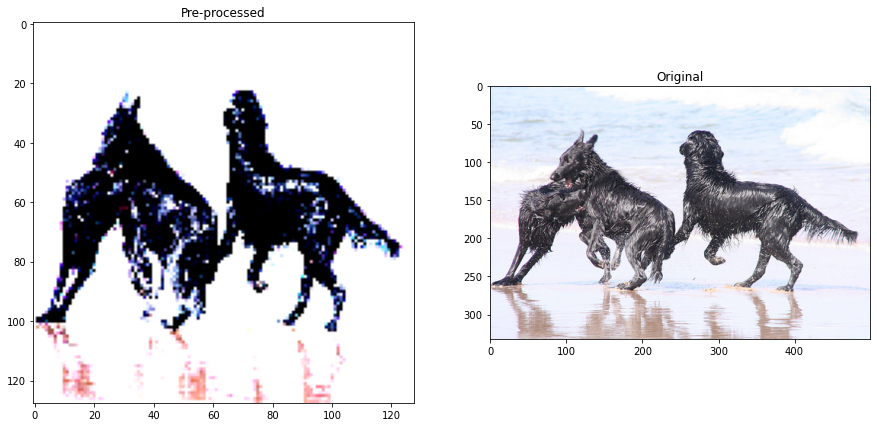

In [65]:
img, caption = list(dataset.as_numpy_iterator())[1234]
fig, (ax1,ax2) = pyplot.subplots(nrows=1,ncols=2,figsize=(15,10))
ax1.imshow(img)
ax1.set_title("Pre-processed")
original = image.imread(img_paths[1234])
pyplot.imshow(original)
ax2.set_title("Original")

caption

In [66]:
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)
index_to_word(caption)

<tf.Tensor: shape=(35,), dtype=string, numpy=
array([b'[START]', b'three', b'large', b'black', b'dogs', b'are',
       b'playing', b'on', b'the', b'shore', b'near', b'the', b'ocean',
       b'[END]', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'', b'',
       b'', b'', b'', b'', b'', b'', b'', b'', b'', b''], dtype=object)>

In [ ]:
#https://www.hackersrealm.net/post/image-caption-generator-using-python